In [2]:
import sys
sys.path.insert(0, "..")
from geometry_metrics import generate_grid_in_embedding_space

grid, edges = generate_grid_in_embedding_space((2, 3, 4), embedding_space_dimension=100, distortion_magnitude=1, show_edges=True)

3 24


In [3]:
import numpy as np

In [4]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
grid_3d = pca.fit_transform(grid)
print(grid_3d.shape)

(24, 3)


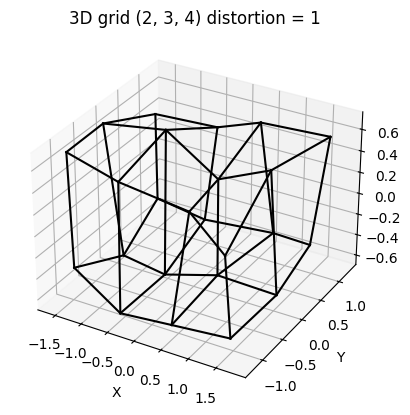

In [5]:

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create the figure and axes
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# distance = lambda x, y: (x - y).dot(x - y)
# for edge in edges:
#     print(distance(rotated_vertices[edge[0]], rotated_vertices[edge[1]]))

# Plot the cube
for edge in edges:
    ax.plot([grid_3d[edge[0]][0], grid_3d[edge[1]][0]],
            [grid_3d[edge[0]][1], grid_3d[edge[1]][1]],
            [grid_3d[edge[0]][2], grid_3d[edge[1]][2]], 'k-')

# Set axis labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# # # Set axis limits
# ax.set_xlim(-.5, 1.5)
# ax.set_ylim(-.5, 1.5)
# ax.set_zlim(-.5, 1.5)

# Show the plot
plt.title("3D grid (2, 3, 4) distortion = 1")
plt.show()

In [6]:
from geometry_metrics import shattering_dimensionality, span_to_gaussian_cloud
from sklearn.linear_model import RidgeClassifier
sd = shattering_dimensionality(grid, 100, 0.2, sample_dichotomy=100)

#sampling dichotomy: 100 100


In [31]:
def linear_decoding_score_span_gaussion(points,
        train_points_index, train_labels, test_points_index, test_labels,
        nsamples = 100, noise_coef = 0.0
    ):

    X_train = span_to_gaussian_cloud(points[train_points_index, :], nsamples, noise_coef)
    y_train = np.repeat(train_labels, nsamples)


    X_test = span_to_gaussian_cloud(points[test_points_index, :], nsamples, noise_coef)
    y_test = np.repeat(test_labels, nsamples)

    print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
    svc = RidgeClassifier()
    svc.fit(X_train, y_train)
    score = svc.score(X_test, y_test)
    # all_score.append(score)
    return score

In [32]:
def CCGP_grid_lastdim(points, grid_shape, decoding_dimensions = None, nsamples = 100, noise_coef = 0.2,
              sample_training_split = 0.75, top_K = None, verbose = False):
    '''
        Calculate the CCGP of a grid and take the last dimension as decoding variable
        points:
        grid_shape: used to determine which directions we care about
        decoding_dimensions: None or integer or list
    '''
    num_dim = len(grid_shape)
    num_vertex = points.shape[0]
    if decoding_dimensions is None:
        decoding_dimensions = list(range(num_dim))
    elif type(decoding_dimensions) is int:
        decoding_dimensions = [decoding_dimensions]
     
    # we first decode along the last dimension
    num_context = num_vertex // grid_shape[-1]
    num_label = grid_shape[-1]
    # num_training_context = num_context-1
    # num_test_context = 1
    score_all = []
    for test_context in range(num_context):
        test_points_base = num_label * test_context
        test_points_index = list(range(test_points_base, test_points_base + num_label))
        test_label = list(range(num_label))
        train_points_index = [x for x in range(num_vertex) if x not in test_points_index]
        train_label = list(range(num_label)) * (num_context - 1)
        print(train_points_index, train_label, test_points_index, test_label)
        score = linear_decoding_score_span_gaussion(points, train_points_index, train_label,
                                            test_points_index, test_label, noise_coef=noise_coef)
        score_all.append(score)
    return np.mean(score_all)


In [33]:
grid_shape = (3, 3)
grid = generate_grid_in_embedding_space(grid_shape, embedding_space_dimension=100, distortion_magnitude=1)
CCGP_grid(grid, grid_shape)


2 9
[3, 4, 5, 6, 7, 8] [0, 1, 2, 0, 1, 2] [0, 1, 2] [0, 1, 2]
(600, 100) (600,) (300, 100) (300,)
[0, 1, 2, 6, 7, 8] [0, 1, 2, 0, 1, 2] [3, 4, 5] [0, 1, 2]
(600, 100) (600,) (300, 100) (300,)
[0, 1, 2, 3, 4, 5] [0, 1, 2, 0, 1, 2] [6, 7, 8] [0, 1, 2]
(600, 100) (600,) (300, 100) (300,)


0.7644444444444445

In [57]:
dim = 40
num_variable = 2
lower_bound, upper_bound = 0, 1

num_points_training = 100
num_points_testing = 10

noise_coef = 0.2

np.random.seed(44)
point_training = np.zeros((num_points_training, dim), dtype='float')
point_training[:, :num_variable] = np.random.rand(num_points_training, num_variable)

point_testing = np.zeros((num_points_testing, dim), dtype='float')
point_testing[:, :num_variable] = np.random.rand(num_points_testing, num_variable)

print(point_training.shape, point_testing.shape)

linear_function = lambda cos: 7*cos[0] + 5*cos[1]

value_training = np.apply_along_axis(linear_function, axis=1, arr = point_training)
value_testing = np.apply_along_axis(linear_function, axis=1, arr = point_testing)
print(value_training.shape, value_testing.shape)

(100, 40) (10, 40)
(100,) (10,)


40 2 0 normal 1.0 0.9999999999999998
40 2 0 generalization 1.0 0.9999999999999998
40 2 0.2 normal 0.600479955733142 0.7780265696742573
40 2 0.2 generalization -2.37106207192406 0.8317113362958136
40 2 0.4 normal 0.3837794201232375 0.6213778127912353
40 2 0.4 generalization -5.565569551857637 0.4502231649713692
40 2 0.6 normal -0.005906638589386226 0.244213096663469
40 2 0.6 generalization -9.03063995648547 0.23880770936770418
40 2 0.8 normal 0.06815469796830176 0.30243466361009275
40 2 0.8 generalization -11.040069727719406 0.2305235503054365
40 2 1 normal 0.10532238211095646 0.3647768551325829
40 2 1 generalization -9.802034742425782 0.20383856267716924
40 3 0 normal 1.0 0.9999999999999998
40 3 0 generalization 1.0 0.9999999999999999
40 3 0.2 normal 0.6014279159618128 0.7787795429792485
40 3 0.2 generalization -3.3852201141685567 0.797162245143662
40 3 0.4 normal 0.22769004333863618 0.49320880034165043
40 3 0.4 generalization -5.328233768218798 0.6336008458400958
40 3 0.6 normal 0.153